In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

In [23]:
import pysixtrack
import sixtracklib as stl

In [3]:
from scipy.constants import e, m_p, c, epsilon_0
from scipy.constants import physical_constants

# VERSIONING

## PySixTrack:

In [4]:
import os
f = os.path.dirname(pysixtrack.__file__)
f

'/home/oeftiger/gsi/git/pysixtrack_hannes/pysixtrack'

In [5]:
!cd $f && git log | head -4

commit 4ce2927b4bd5df52670b3f08b12231a12c8fd53b
Author: Hannes Bartosik <hannes.bartosik@cern.ch>
Date:   Wed Jan 8 08:24:11 2020 +0100



## SixTrackLib:

In [24]:
import os
f = os.path.dirname(stl.__file__)
f

'/home/oeftiger/gsi/git/sixtracklib/python/sixtracklib'

In [25]:
!cd $f && git log | head -4

commit 0539914c228a66820427b2c7d333725fcc02ebd7
Merge: 00d1a3a7 af5af8ea
Author: Martin Schwinzerl <martin.schwinzerl@cern.ch>
Date:   Mon Dec 16 19:05:33 2019 +0100


# Parameters

In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3

In [7]:
npart = 1000

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

sc_mode = 'Bunched'
intensity = 0.625e11

sig_z = 58 / 4. # in m

###
mass_eV = A * nmass * 1e9
mass = mass_eV * e / c**2 # in kg
charge = Q * e # in Coul

lmbda = intensity * charge / (np.sqrt(2*np.pi) * sig_z) # max. line charge density

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

First space charge node in SIS100 gets these values:

In [8]:
sigma_x = 0.01181161979882409
sigma_y = 0.004310223297587457
sc_node_length = 2.1672000003199985

Gaussian field linearised in the bunch centre, evaluated at 1 sigma [[Adrian's thesis](http://cds.cern.ch/record/2233212?ln=en), Eq. 2.82]:

In [9]:
eg = lmbda / (2 * np.pi * epsilon_0) * 1 / (sigma_x + sigma_y)

force from electric field, renormalised into (kick / ds) units [Eqs. 3.31 and 3.32]:

In [10]:
kg = charge * eg / (gamma**2) / p0 * 1 / (beta * c)

# A. SC kicks in PySixTrack

In [11]:
sc_node = pysixtrack.be_beamfields.spacecharge.SpaceChargeBunched(
    number_of_particles=intensity, bunchlength_rms=sig_z, 
    sigma_x=sigma_x, 
    sigma_y=sigma_y, 
    length=sc_node_length, 
    x_co=0.0, y_co=0.0, min_sigma_diff=1e-30, enabled=True)

## horizontal bunch field at $z=0$

In [12]:
pysixtrack_particles = pysixtrack.Particles(p0c=p0c, mass0=mass_eV, q0=Q)

x0 = np.linspace(-3*sc_node.sigma_x, 3*sc_node.sigma_x, npart)

pysixtrack_particles.x = x0

In [13]:
sc_node.track(pysixtrack_particles)

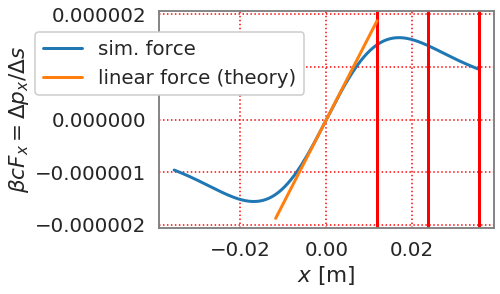

In [14]:
plt.plot(pysixtrack_particles.x, pysixtrack_particles.px / sc_node.length, label='sim. force')

plt.axvline(sigma_x, color='red')
plt.axvline(2 * sigma_x, color='red')
plt.axvline(3 * sigma_x, color='red')

plt.ylabel(r'$\beta c F_x =\Delta p_x / \Delta s$')
plt.xlabel('$x$ [m]')

plt.plot([-sigma_x, sigma_x], [-kg, kg], color='C1', label='linear force (theory)')
plt.legend(loc=2, framealpha=1, bbox_to_anchor=(-0.4, 0.95))

## vertical bunch field at $z=0$

In [15]:
pysixtrack_particles = pysixtrack.Particles(p0c=p0c, mass0=mass_eV, q0=Q)

y0 = np.linspace(-3*sc_node.sigma_y, 3*sc_node.sigma_y, npart)

pysixtrack_particles.y = y0

In [16]:
sc_node.track(pysixtrack_particles)

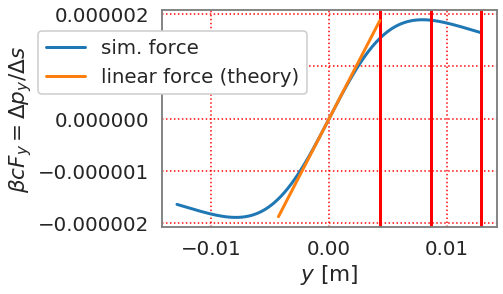

In [17]:
plt.plot(pysixtrack_particles.y, pysixtrack_particles.py / sc_node.length, label='sim. force')

plt.axvline(sigma_y, color='red')
plt.axvline(2 * sigma_y, color='red')
plt.axvline(3 * sigma_y, color='red')

plt.ylabel(r'$\beta c F_y =\Delta p_y / \Delta s$')
plt.xlabel('$y$ [m]')

plt.plot([-sigma_y, sigma_y], [-kg, kg], color='C1', label='linear force (theory)')
plt.legend(loc=2, framealpha=1, bbox_to_anchor=(-0.4, 0.95))

## longitudinal impact on field particle in horizontal linear regime

In [18]:
pysixtrack_particles = pysixtrack.Particles(p0c=p0c, mass0=mass_eV, q0=Q)

z0 = np.linspace(-3*sc_node.bunchlength_rms, 3*sc_node.bunchlength_rms, npart)

pysixtrack_particles.x = np.ones(npart) * sigma_x * 0.1
pysixtrack_particles.zeta = z0

In [19]:
sc_node.track(pysixtrack_particles)

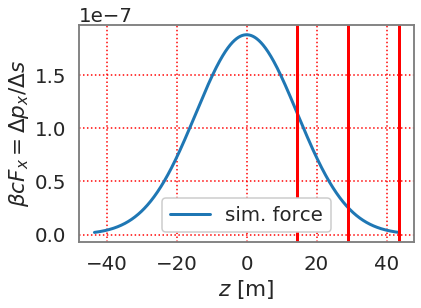

In [20]:
plt.plot(pysixtrack_particles.zeta, pysixtrack_particles.px / sc_node.length, label='sim. force')

plt.axvline(sig_z, color='red')
plt.axvline(2 * sig_z, color='red')
plt.axvline(3 * sig_z, color='red')

plt.ylabel(r'$\beta c F_x =\Delta p_x / \Delta s$')
plt.xlabel('$z$ [m]')
plt.legend(loc=8, framealpha=1)

In [21]:
sig_z == sc_node.bunchlength_rms

True

In [22]:
type(sc_node)

pysixtrack.be_beamfields.spacecharge.SpaceChargeBunched

# B. SC kicks in SixTrackLib

In [32]:
elements = stl.Elements()

elements.SpaceChargeBunched(
    number_of_particles=intensity, bunchlength_rms=sig_z, 
    sigma_x=sigma_x, 
    sigma_y=sigma_y, 
    length=sc_node_length, 
    x_co=0.0, y_co=0.0, min_sigma_diff=1e-30, enabled=True)

## horizontal bunch field at $z=0$

In [38]:
particles = stl.Particles.from_ref(npart, p0c=p0c, mass0=mass_eV, q0=Q)

x0 = np.linspace(-3*sigma_x, 3*sigma_x, npart)

particles.x[:] = x0

In [40]:
trackjob = stl.TrackJob(elements, particles)

trackjob.track(1)

trackjob.collect()

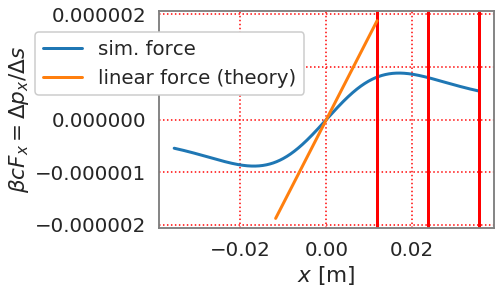

In [45]:
plt.plot(particles.x, particles.px / sc_node_length, label='sim. force')

plt.axvline(sigma_x, color='red')
plt.axvline(2 * sigma_x, color='red')
plt.axvline(3 * sigma_x, color='red')

plt.ylabel(r'$\beta c F_x =\Delta p_x / \Delta s$')
plt.xlabel('$x$ [m]')

plt.plot([-sigma_x, sigma_x], [-kg, kg], color='C1', label='linear force (theory)')
plt.legend(loc=2, framealpha=1, bbox_to_anchor=(-0.4, 0.95))

## vertical bunch field at $z=0$

In [46]:
particles = stl.Particles.from_ref(npart, p0c=p0c, mass0=mass_eV, q0=Q)

y0 = np.linspace(-3*sc_node.sigma_y, 3*sc_node.sigma_y, npart)

particles.y[:] = y0

In [53]:
try:
    del trackjob
except:
    pass

trackjob = stl.TrackJob(elements, particles)

trackjob.track(1)

trackjob.collect()

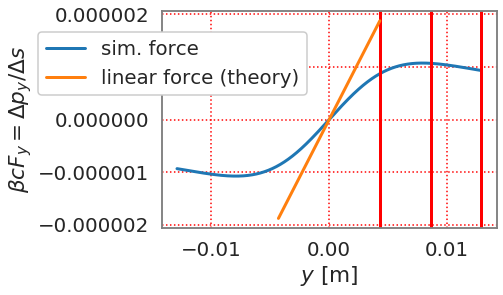

In [55]:
plt.plot(particles.y, particles.py / sc_node_length, label='sim. force')

plt.axvline(sigma_y, color='red')
plt.axvline(2 * sigma_y, color='red')
plt.axvline(3 * sigma_y, color='red')

plt.ylabel(r'$\beta c F_y =\Delta p_y / \Delta s$')
plt.xlabel('$y$ [m]')

plt.plot([-sigma_y, sigma_y], [-kg, kg], color='C1', label='linear force (theory)')
plt.legend(loc=2, framealpha=1, bbox_to_anchor=(-0.4, 0.95))

## longitudinal impact on field particle in horizontal linear regime

In [57]:
particles = stl.Particles.from_ref(npart, p0c=p0c, mass0=mass_eV, q0=Q)

z0 = np.linspace(-3*sig_z, 3*sig_z, npart)

particles.x[:] = np.ones(npart) * sigma_x * 0.1
particles.zeta[:] = z0

In [58]:
try:
    del trackjob
except:
    pass

trackjob = stl.TrackJob(elements, particles)

trackjob.track(1)

trackjob.collect()

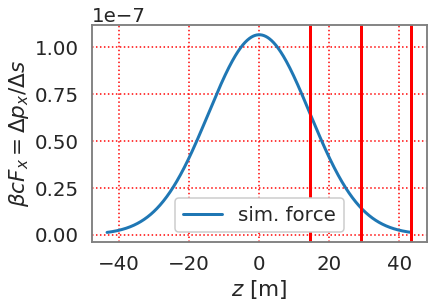

In [59]:
plt.plot(particles.zeta, particles.px / sc_node_length, label='sim. force')

plt.axvline(sig_z, color='red')
plt.axvline(2 * sig_z, color='red')
plt.axvline(3 * sig_z, color='red')

plt.ylabel(r'$\beta c F_x =\Delta p_x / \Delta s$')
plt.xlabel('$z$ [m]')
plt.legend(loc=8, framealpha=1)